In [65]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
#export
from exp.nb_04 import *

# 先尝试在第一个layer上做好退火

## 回顾上一个notebook的果实

In [67]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [68]:
data = DataBunch(*get_dls(train_ds,valid_ds,bs),c)

In [69]:
#export
def create_learner(model_func,loss_func,data):
    return Learner(*model_func(data),loss_func,data)

In [70]:
learn = create_learner(get_model,loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])
run.fit(3,learn)

train: [0.668152265625, tensor(0.8063)]
valid: [0.29599150390625, tensor(0.9141)]
train: [0.295085859375, tensor(0.9143)]
valid: [0.2507198974609375, tensor(0.9269)]
train: [0.23827462890625, tensor(0.9309)]
valid: [0.208123828125, tensor(0.9418)]


## 调整一下学习率　为0.3
因为需要使用partial，我们进一步重构

In [71]:
learn = create_learner(partial(get_model,lr=0.3),loss_func,data)
run = Runner([AvgStatsCallback([accuracy])])
run.fit(3,learn)

train: [0.772236875, tensor(0.7974)]
valid: [0.3615467041015625, tensor(0.9007)]
train: [0.3510583984375, tensor(0.8997)]
valid: [0.2913885986328125, tensor(0.9188)]
train: [0.300328984375, tensor(0.9142)]
valid: [0.2723429443359375, tensor(0.9230)]


In [72]:
#export
def get_model_func(lr=0.5):
    return partial(get_model,lr=lr)

## 退火Annealing
我们定义两个新的回调函数
1. Recorder来记录一下所有的 **loss**和**learning rate** 
2. ParamSchduler可以调度一些超参数（在优化器的state_dict中注册）

In [73]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [74]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

使用装饰器进行重构，从而复用

In [75]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [76]:
f = sched_lin(1,2)
f(0.3)

1.3

In [77]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

为了让matplotlib可以画出tensor，我们人为的定义ndim这一个属性，这是python的牛逼之处

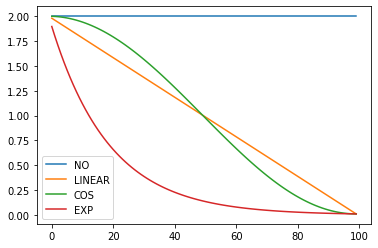

In [78]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

来一个大杂烩

In [79]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [80]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [81]:
plt.plot(a, [sched(o) for o in p])

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [82]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [83]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [84]:
run.fit(3,learn)

train: [0.797687109375, tensor(0.7759)]
valid: [0.3511754150390625, tensor(0.8953)]
train: [0.30464474609375, tensor(0.9112)]
valid: [0.2386136962890625, tensor(0.9321)]
train: [0.2403376953125, tensor(0.9314)]
valid: [0.2142770263671875, tensor(0.9406)]


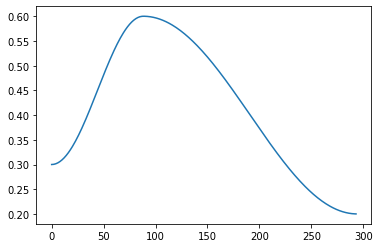

In [85]:
run.recorder.plot_lr()

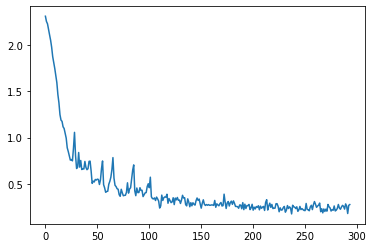

In [86]:
run.recorder.plot_loss()

# Export

In [ ]:
!python 